<a href="https://colab.research.google.com/github/mafaldasalomao/multilabel_classification_pocus/blob/main/multilabel_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import suppporting libraries
import tarfile
import urllib.request as urllib2
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
#Import deep learning libraries
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tqdm as tqdm
import tensorflow_hub as hub

#Import data analytics libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
#Import image visualization libraries
from PIL import *
from PIL import ImageFile
from PIL import Image
#System settings
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['WANDB_CONSOLE'] = 'off'
#Coloring for print outputs
class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp  /content/drive/MyDrive/datasets/convex.zip /content/

In [2]:
!unzip -q convex.zip -d /content/temp

In [2]:
path='/content/temp/convex'
annotation_path = "dataset_metadata.csv"
videos_list = os.listdir(path)

In [3]:
columns = ['Filename', 'Effusion', 'Consolidations', 'B-lines', 'A-lines', 'Pleural_line_irregularities', 'Air_bronchogram', 'Label']
base = pd.read_csv(annotation_path, usecols=columns)

In [4]:
base = base[base['Effusion'] != 'n/A']
base = base[base['Consolidations'] != 'n/A']
base = base[base['B-lines'] != 'n/A']
base = base[base['A-lines']  != 'n/A']
base = base[base['Pleural_line_irregularities']  != 'n/A']
base = base[base['Air_bronchogram']  != 'n/A']
base = base[base['Label']  != 'n/A']
#base = base[base['Label']  != 'regular']
#base = base[base['Label']  != 'Regular']
base['Label']= base['Label'].replace(['regular'], 'Regular')

base['Effusion'] = pd.to_numeric(base['Effusion'])
base.head()

,Filename,Label,Effusion,Consolidations,B-lines,A-lines,Pleural_line_irregularities,Air_bronchogram
0,Cov-Butterfly-COVID Lung 2,COVID-19,1.0,0.0,1.0,0.0,1.0,0.0
1,Cov-Butterfly-Skip Lesion,COVID-19,0.0,1.0,1.0,1.0,1.0,0.0
2,Cov-Butterfly-Confluent B lines,COVID-19,0.0,0.0,1.0,0.0,0.0,0.0
3,Reg-Butterfly-Normal Lung A lines,Regular,0.0,0.0,0.0,1.0,0.0,0.0
4,Reg-Butterfly-Normal Lung_Example 2,Regular,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
base  = base.dropna(axis = 0)
base.shape

(346, 8)

In [6]:
metadata = base;
metadata['Filename']

0               Cov-Butterfly-COVID Lung 2
1                Cov-Butterfly-Skip Lesion
2          Cov-Butterfly-Confluent B lines
3        Reg-Butterfly-Normal Lung A lines
4      Reg-Butterfly-Normal Lung_Example 2
                      ...                 
344                Cov-B_ConvexProb_score1
345               Cov-C_Convex_Prob_score2
346               Cov-D_Convex_Prob_score3
347                Cov-C_ConvexProb_score3
348                    Cov-MSU-SkipLesions
Name: Filename, Length: 346, dtype: object

In [ ]:
#"Cov-Butterfly-COVID Lung 2" in metadata['Filename']
teste = metadata.loc[metadata.Filename == "Reg-Atlas-lungcurtain"]
len(teste)

1

In [7]:
effusion_list = []
consolid_list = []
aline_list = []
bline_list = []
pli_list = []
airb_list = []
filenames = []
y_labels = []
os.mkdir("/content/dataset")

FileExistsError: ignored

In [8]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
num_imgs_per_video=10

In [ ]:

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
feature_extractor_layer.trainable = True

In [9]:
def plot_curves(history):
    plt.figure(figsize=(5, 3))
    epochs = range(1, len(history.history['loss'])+1)
    plt.plot(epochs, history.history['loss'], label="Train loss")
    plt.plot(epochs, history.history['val_loss'], label="Test Loss")
    plt.title("Training Loss Curve")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();
    
    plt.figure(figsize=(5, 3))
    epochs = range(1, len(history.history['accuracy'])+1)
    plt.plot(epochs, history.history['accuracy'], label="Train Acc")
    plt.plot(epochs, history.history['val_accuracy'], label="Test Acc")
    plt.title("Training Accuracy Curve")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

## Data Augmentation


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-505ow_a_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-505ow_a_


In [ ]:
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout

In [ ]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)

In [ ]:
from scipy.stats.distributions import alpha
def create_dataset_aug(img_altura=224, img_largura=224, augmentation=True):
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = '/content/dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    cv2.imwrite(out, image)
                    img = tf.keras.utils.load_img(out, target_size = (img_largura, img_altura, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    X_train.append(img)
                    img_labels = [metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]],
                                    metadata['Consolidations'][metadata_cap.index[0]],
                                    metadata['Pleural_line_irregularities'][metadata_cap.index[0]]]
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                    y_train.append(img_labels)
                    if augmentation:
                      aug = HorizontalFlip(p = 1.0)
                      augmentation = aug(image = img)
                      x1 = augmentation['image']
                      X_train.append(x1)
                      y_train.append(img_labels)

                      aug = OpticalDistortion(p = 1.0, distort_limit=2, shift_limit=0.5)
                      augmentation = aug(image = img)
                      x2 = augmentation['image']
                      X_train.append(x2)
                      y_train.append(img_labels)

                      # aug = ElasticTransform(p = 1.0, alpha=120, sigma=120*0.05, alpha_affine=120*0.03)
                      # augmentation = aug(image = img)
                      # x3 = augmentation['image']
                      # X_train.append(x3)
                      # y_train.append(img_labels)

                      # aug = GridDistortion(p = 1.0)
                      # augmentation = aug(image = img)
                      # x4 = augmentation['image']
                      # X_train.append(x4)
                      # y_train.append(img_labels)

                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [10]:
def create_mydataset_all():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = '/content/dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    cv2.imwrite(out, image)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]],
                                    metadata['Consolidations'][metadata_cap.index[0]],
                                    metadata['Pleural_line_irregularities'][metadata_cap.index[0]]])
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [11]:
#X, y = create_dataset_aug()
X, y = create_mydataset_all()
#((1225, 224, 224, 3), (1225, 5))
num_folds=5
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
del X
del y
X_train.shape, y_train.shape

((2668, 224, 224, 3), (2668, 5))

In [ ]:
reconstructed_model = keras.models.load_model("my_h5_model.h5")

In [23]:
#del X
#del y
#from keras import initializers
#tf.random.set_seed(42)
batch_size = 32
acc_per_fold = []
loss_per_fold = []

## K-fold

In [24]:
# K-fold Cross Validation model evaluation
N_LABELS = 5
EPOCHS = 30
LR = 1e-4
batch_size = 32
fold_no = 1
for train, test in kfold.split(X, y):

  # Define the model architecture
  initializer = tf.keras.initializers.Identity()
  model_all_0 = tf.keras.Sequential([
      feature_extractor_layer_resnet,
      Dense(2048, activation='relu', name='hidden_layer_1'),
      Dense(1024, activation='relu', name='hidden_layer_2'),
      Dense(256, activation='relu', name='hidden_layer_3'),
      Dense(64, activation='relu', name='hidden_layer_4'),
      Dense(N_LABELS, activation='sigmoid', name='output')
  ])
  # Compile the model
  model_all_0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy'])



  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model_all_0.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=EPOCHS,
              validation_data = (X[test], y[test]))

  # Generate generalization metrics
  scores = model_all_0.evaluate(X[test], y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model_all_0.metrics_names[0]} of {scores[0]}; {model_all_0.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
39/39 [==============================] - 11s 218ms/step - loss: 0.3552 - accuracy: 0.3371 - val_loss: 0.2242 - val_accuracy: 0.6091
Epoch 2/30
39/39 [==============================] - 7s 189ms/step - loss: 0.1516 - accuracy: 0.5714 - val_loss: 0.1104 - val_accuracy: 0.6352
Epoch 3/30
39/39 [==============================] - 7s 191ms/step - loss: 0.0721 - accuracy: 0.5878 - val_loss: 0.0611 - val_accuracy: 0.6221
Epoch 4/30
39/39 [==============================] - 8s 194ms/step - loss: 0.0324 - accuracy: 0.5829 - val_loss: 0.0433 - val_accuracy: 0.6221
Epoch 5/30
39/39 [==============================] - 8s 195ms/step - loss: 0.0180 - accuracy: 0.5739 - val_loss: 0.0370 - val_accuracy: 0.6352
Epoch 6/30
39/39 [==============================] - 9s 221ms/step - loss: 0.0107 - accuracy: 0.5869 - val_loss: 0.0248 - val_accuracy: 0.6482
Epoch 7/30
39/39 [==============================] 

In [25]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.017717860639095306 - Accuracy: 59.93485450744629%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.010268652811646461 - Accuracy: 57.980453968048096%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.025271903723478317 - Accuracy: 56.209152936935425%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.012337586842477322 - Accuracy: 53.26797366142273%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.020696312189102173 - Accuracy: 59.80392098426819%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 57.439271211624146 (+- 2.490995685726579)
> Loss: 0.017258463241159917
--------------

In [26]:
model_all_0.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              42626560  
                                                                 
 hidden_layer_1 (Dense)      (None, 2048)              4196352   
                                                                 
 hidden_layer_2 (Dense)      (None, 1024)              2098176   
                                                                 
 hidden_layer_3 (Dense)      (None, 256)               262400    
                                                                 
 hidden_layer_4 (Dense)      (None, 64)                16448     
                                                                 
 output (Dense)              (None, 5)                 325       
                                                                 
Total params: 49,200,261
Trainable params: 6,573,701


In [ ]:
# Save the model
model_all_0.save('my_model_0_1(88-90).h5')

## BackBone Resnet

In [12]:
feature_extractor_url_resnet = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5"
feature_extractor_layer_resnet = hub.KerasLayer(feature_extractor_url_resnet,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
print("Thickness of the model:", len(feature_extractor_layer_resnet.weights))
#list(feature_extractor_layer_resnet.layers)

In [13]:
feature_extractor_layer_resnet.trainable = False

In [ ]:
tf.random.set_seed()

## Unity Test

In [19]:
N_LABELS = 5
EPOCHS = 25
LR = 1e-4
batch_size = 32
##################
#2048-5 = 
initializer = tf.keras.initializers.Identity()
model_all_0 = tf.keras.Sequential([
    feature_extractor_layer_resnet,
    Dense(2048, activation='relu', name='hidden_layer_1'),
    Dense(64, activation='relu', name='hidden_layer_2'),
    Dense(64, activation='relu', name='hidden_layer_3'),
    Dense(16, activation='relu', name='hidden_layer_4'),
    Dense(N_LABELS, activation='sigmoid', name='output')
])
# Compile the model
model_all_0.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'])

history = model_all_0.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=EPOCHS,
            validation_data=(X_test, y_test))

NameError: ignored

## Experiments

### Tested Models


In [22]:
print("2048-64-64-16-5.. [50-67]")
print("2048-1024-256-32-5.. [57]")
print("2048-1024-256-16-5.. [51-61]")
print("2048-1024-256-64-5.. [53-60]")

2048-64-64-16-5.. [50-67]
2048-1024-256-32-5.. [57]
2048-1024-256-16-5.. [55-61]


### Not tested


2048-1024-256-64-5


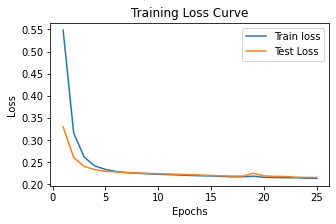

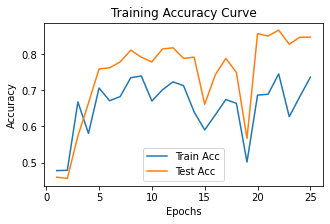

In [ ]:
print("2048-1024-256-64-5")
plot_curves(history)

2048-1024-256-128-5


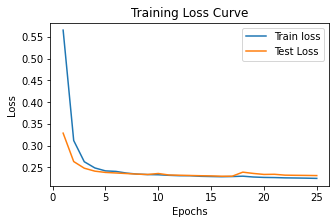

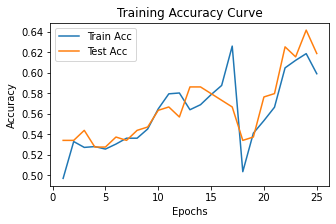

In [ ]:
print("2048-1024-256-128-5")
plot_curves(history)

2048-1024-512-16-5, +25 epochs


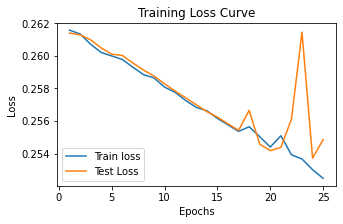

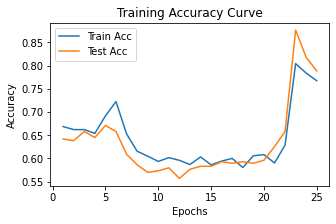

In [ ]:
print("2048-1024-512-16-5, +25 epochs")
plot_curves(history)

2048-1024-512-16-5


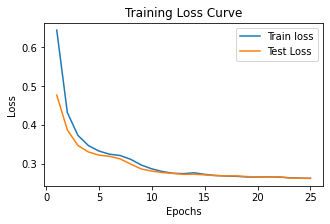

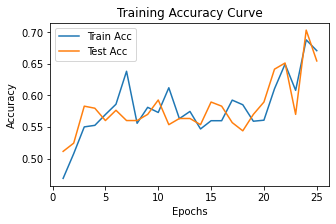

In [ ]:
print("2048-1024-512-16-5")
plot_curves(history)

2048-1024-512-32-5


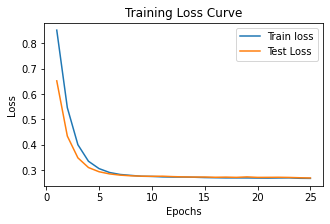

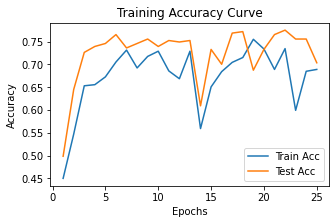

In [ ]:
print("2048-1024-512-32-5")
plot_curves(history)

2048-1024-512-64-5


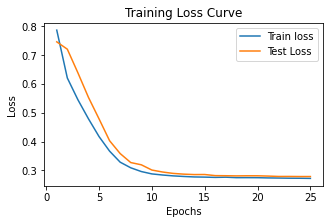

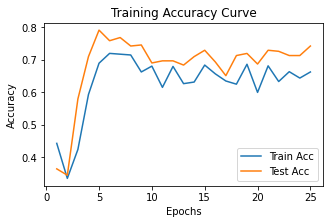

In [ ]:
print("2048-1024-512-64-5")
plot_curves(history)

2048-1024-1024-5, non freezed layers, activation: Relu


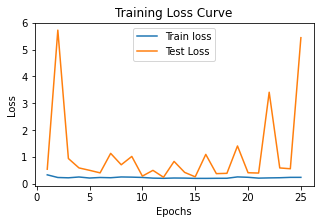

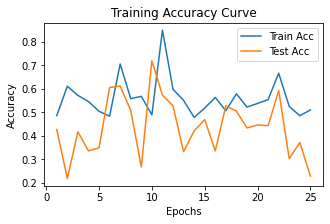

In [ ]:
print("2048-1024-1024-5, non freezed layers, activation: Relu")
plot_curves(history)

In [ ]:
#######################################################################################

2048-512-512-5, non freezed layers, activation: Relu


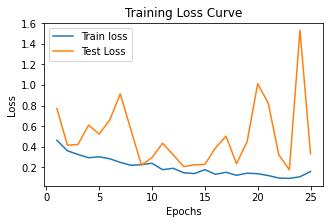

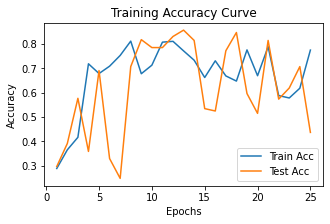

In [ ]:
print("2048-512-512-5, non freezed layers, activation: Relu")
plot_curves(history)

2048-128-64-5, non freezed layers, activation: Relu


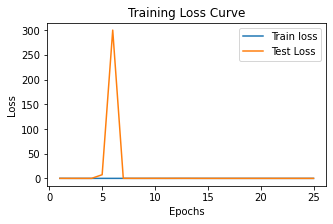

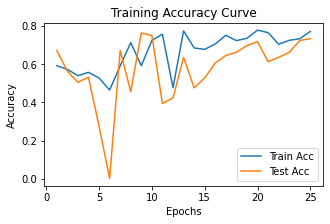

In [ ]:
print("2048-128-64-5, non freezed layers, activation: Relu")
plot_curves(history)

2048-128-10-5, non freezed layers, activation: Relu


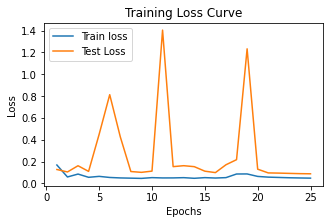

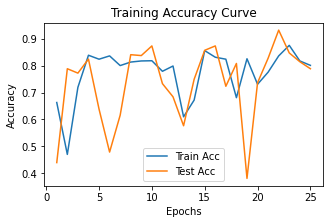

In [ ]:
print("2048-128-10-5, non freezed layers, activation: Relu")
plot_curves(history)

In [ ]:
############################################################################

2048-64-64-5, non freezed layers, activation: Relu


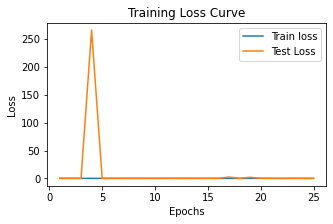

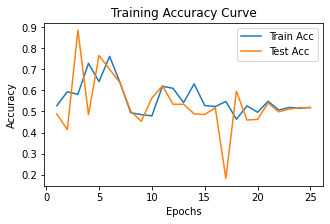

In [ ]:
print("2048-64-64-5, non freezed layers, activation: Relu")
plot_curves(history)